In [ ]:
import face_alignment

from exchange_dialogues_params import *
from exchange_dialogues_functions import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import time

In [51]:
config = MovieTranslationConfig()
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, enable_cuda=True, flip_input=False, use_cnn_face_detector=False)

# Transform 3D face pose and project 2D landmarks

1. Read 2 images
2. Read their landmarks
3. Plot the images and their landmarks
4. Transform the landmarks of one image to match the pose of the other image's face
5. Plot new landmarks

## 1. Read 2 images

In [2]:
im0 = cv2.cvtColor(cv2.imread('/home/voletiv/Datasets/MOVIE_TRANSLATION/frames/telugu/Mahesh_Babu/Mahesh_Babu_0000/Mahesh_Babu_0000_frame_025.png'), cv2.COLOR_BGR2RGB)

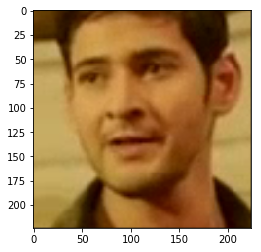

In [3]:
plt.imshow(im0)

In [4]:
im1 = cv2.cvtColor(cv2.imread('/home/voletiv/Datasets/MOVIE_TRANSLATION/frames/telugu/Mahesh_Babu/Mahesh_Babu_0000/Mahesh_Babu_0000_frame_035.png'), cv2.COLOR_BGR2RGB)

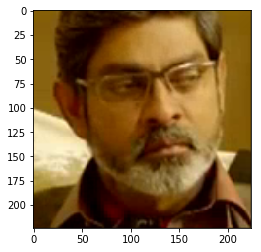

In [5]:
plt.imshow(im1)

## 2. Read their landmarks

In [6]:
# Read landmarks
telugu_Mahesh_Babu_landmarks = read_landmarks('telugu', 'Mahesh_Babu', 0)

# 3D landmarks
lm0 = np.array(telugu_Mahesh_Babu_landmarks[25][1:])
lm1 = np.array(telugu_Mahesh_Babu_landmarks[-1][1:])

In [7]:
print(lm0.shape, lm1.shape)

(68, 3) (68, 3)


## 3. Plot the images and their landmarks

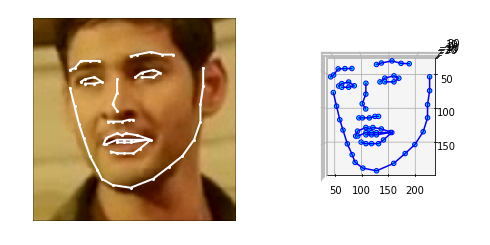

In [8]:
plot_3D_landmarks(im0, lm0)

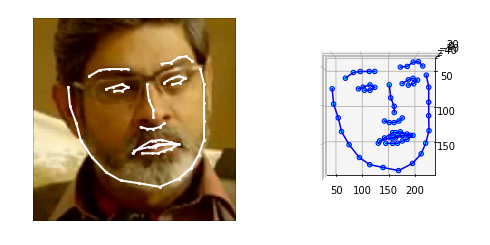

In [9]:
plot_3D_landmarks(im1, lm1)

# Using Homography

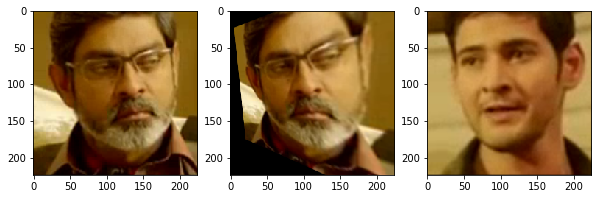

In [55]:
src_img = im1
src_points = lm1[:36, :2]
dst_img = im0
dst_points = lm0[:36, :2]
h, status = cv2.findHomography(src_points, dst_points)
warped_img_1_to_0 = cv2.warpPerspective(src_img, h, (224, 224))

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(src_img)
plt.subplot(132)
plt.imshow(warped_img_0)
plt.subplot(133)
plt.imshow(dst_img)

In [63]:
lm_w_1_to_0 = np.round(fa.get_landmarks(warped_img_1_to_0)[0]).astype('int')

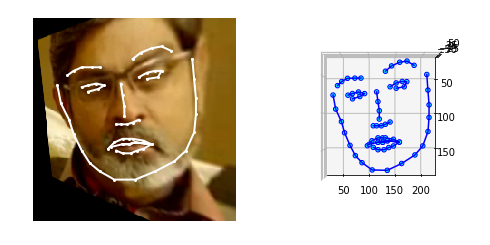

In [65]:
plot_3D_landmarks(warped_img_1_to_0, lm_w_1_to_0)

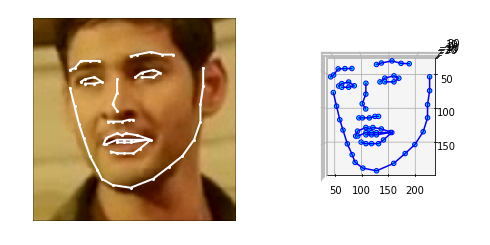

In [66]:
plot_3D_landmarks(im0, lm0)

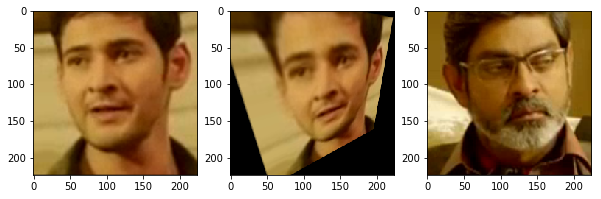

In [72]:
src_points = lm0[:36, :]
dst_points = lm1[:36, :]
src_img = im0
dst_img = im1
h, status = cv2.findHomography(src_points, dst_points)
warped_img_0_to_1 = cv2.warpPerspective(src_img, h, (224, 224))

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(src_img)
plt.subplot(132)
plt.imshow(warped_img)
plt.subplot(133)
plt.imshow(dst_img)

In [69]:
lm_w_0_to_1 = np.round(fa.get_landmarks(warped_img_0_to_1)[0]).astype('int')

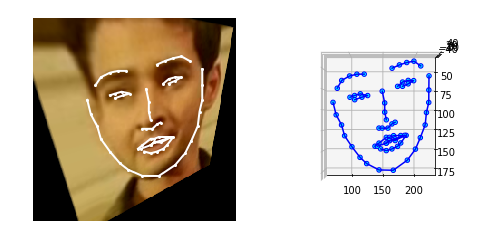

In [70]:
plot_3D_landmarks(warped_img_0_to_1, lm_w_0_to_1)

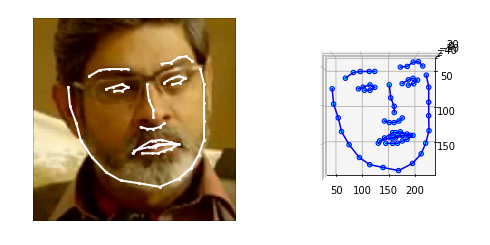

In [71]:
plot_3D_landmarks(im1, lm1)

## 4. Find yaw, pitch, roll

-----------> x

|

|

v

y

$Pitch$ is rotation about $x$-axis.

$Yaw$ is rotation about $y$-axis.

$Roll$ is rotation about $z$-axis.

![alt text](yaw_pitch_roll.png "Title")

In [14]:
def find_yaw_pitch_roll(img_points):
    obj_pts = np.array([[-36.9522, 39.3518, 47.1217],
                        [35.446, 38.4345, 47.6468],
                        [-0.0697709, 18.6015, 87.9695],
                        [-27.6439, -29.6388, 73.8551],
                        [28.7793, -29.2935, 72.7329],
                        [-87.2155, 15.5829, -45.1352],
                        [85.8383, 14.9023, -46.3169]
                       ], dtype=np.float32)/35.
    w = 224
    h = 224
    ppa     = (w/2., h/2.)
    fm      = 7.5/1e3
    sensor  = (7.14e-3, 5.36e-3)
    focal   = w*(fm / sensor[0])
    cam_mat = np.array( [[focal, 0, ppa[0]],
                         [0, focal, ppa[1]],
                         [0, 0, 1]], dtype = np.float64
                      )
    dist_coeffs = np.zeros((5,1))
    rvecc = np.zeros((3,1))
    tvecc = np.zeros((3,1))
    flag = cv2.SOLVEPNP_ITERATIVE # tried with SOLVEPNP_EPNP, same error.
    retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, img_points, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
    yaw   = eulerAngles[1]
    pitch = eulerAngles[0]
    roll  = eulerAngles[2]
#     if pitch > 0:
#       pitch = 180 - pitch
#     elif pitch < 0:
#       pitch = -180 - pitch
#     yaw = -yaw
    ypr = yawpitchrolldecomposition(rvec_matrix)
    print(yaw, pitch, roll)
    print(ypr)
    return proj_matrix, yaw, pitch, roll, ypr

In [15]:
def yawpitchrolldecomposition(R):
    import math
    import numpy as np
    sin_x    = math.sqrt(R[2,0] * R[2,0] +  R[2,1] * R[2,1])    
    validity  = sin_x < 1e-6
    if R[2,1] != 0 and R[1, 2] != 0:
        z1    = math.atan2(R[2,0], R[2,1])     # around z1-axis
        x      = math.atan2(sin_x,  R[2,2])     # around x-axis
        z2    = math.atan2(R[0,2], -R[1,2])    # around z2-axis
    else: # gimbal lock
        z1    = 0                                         # around z1-axis
        x      = math.atan2(sin_x,  R[2,2])     # around x-axis
        z2    = 0                                         # around z2-axis

    return np.array([[z1], [x], [z2]])

# yawpitchroll_angles = -180*yawpitchrolldecomposition(rmat)/math.pi
# yawpitchroll_angles[0,0] = (360-yawpitchroll_angles[0,0])%360 # change rotation sense if needed, comment this line otherwise
# yawpitchroll_angles[1,0] = yawpitchroll_angles[1,0]+90

In [10]:
# Image points of im0
image_points_3D_0 = np.array([lm0[38],
                              lm0[44],
                              lm0[30],
                              lm0[48],
                              lm0[54],
                              lm0[00],
                              lm0[16]], dtype='float32')
image_points_0 = np.array(image_points_3D_0[:, :2])

In [11]:
# Image points of im0
image_points_3D_1 = np.array([lm1[38],
                              lm1[44],
                              lm1[30],
                              lm1[48],
                              lm1[54],
                              lm1[00],
                              lm1[16]], dtype='float32')
image_points_1 = np.array(image_points_3D_1[:, :2])

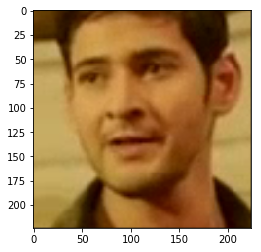

In [12]:
plt.imshow(im0)

In [16]:
proj_0, y_0, p_0, r_0, ypr = find_yaw_pitch_roll(image_points_0)

[-9.56826271] [156.34087584] [5.04331381]
[[-2.74391389]
 [ 2.69797926]
 [-2.86699182]]


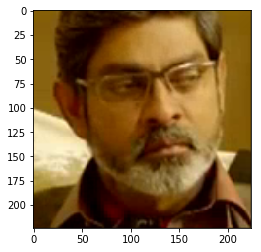

In [17]:
plt.imshow(im1)

In [18]:
proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points_1)

[4.48701588] [150.8325035] [8.03935222]
[[2.98194645]
 [2.6270592 ]
 [2.86201834]]


## 5. Transform landmark points using projection matrix

In [19]:
print(proj_1.shape, lm1.shape)

(3, 4) (68, 3)


In [20]:
lm1_proj = np.dot(proj_1, np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T

In [21]:
proj_1

array([[ 0.98713746, -0.08436629,  0.13580122,  0.28299112],
       [-0.13942457, -0.86994945,  0.47302087, -0.81172879],
       [ 0.07823318, -0.48587065, -0.87052242,  7.9760113 ]])

In [22]:
lm1[0]

array([ 38,  76, -23])

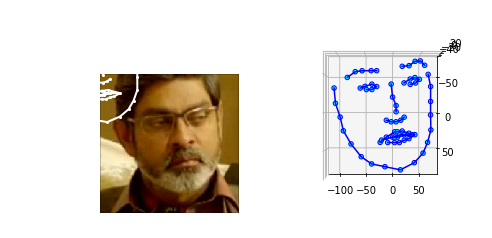

In [23]:
plot_3D_landmarks(im1, lm1-np.mean(lm1, axis=0))

![alt text](yaw_pitch_roll.png "Title")

In [ ]:
ypr

#### YAW - rotation about Y-axis

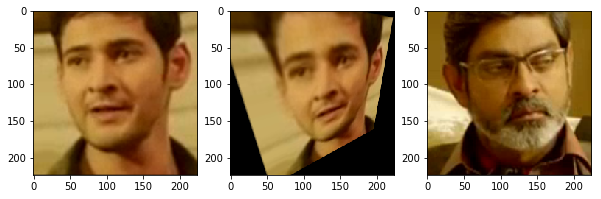

In [73]:
src_points = lm0[:36, :2]
dst_points = lm1[:36, :2]
src_img = im0
dst_img = im1
h, status = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
warped_img_0_to_1 = cv2.warpPerspective(src_img, h, (224, 224))

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(src_img)
plt.subplot(132)
plt.imshow(warped_img)
plt.subplot(133)
plt.imshow(dst_img)

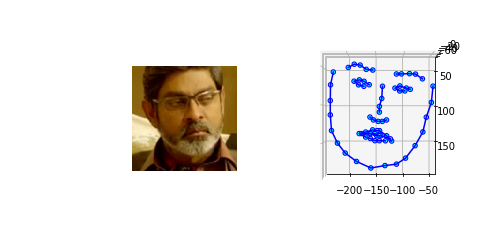

In [24]:
neg_yaw_angle = 2.86386029
lm1_proj_yaw = np.dot(np.array([[ np.cos(neg_yaw_angle), 0, np.sin(neg_yaw_angle), 0], [0, 1, 0, 0], [-np.sin(neg_yaw_angle), 0, np.cos(neg_yaw_angle), 0], [0, 0, 0, 1]]), np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj_yaw[:, :3])

#### ROLL - rotation about Z-axis

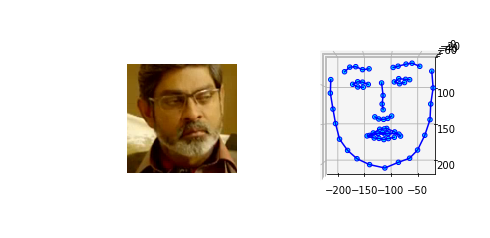

In [25]:
neg_roll_angle = .2
lm1_proj_yaw_done = lm1_proj_yaw[:, :3]
lm1_proj_yaw_roll = np.dot(np.array([[np.cos(neg_roll_angle), np.sin(neg_roll_angle), 0, 0], [-np.sin(neg_roll_angle), np.cos(neg_roll_angle), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), np.hstack((lm1_proj_yaw_done, np.ones(len(lm1_proj_yaw_done)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj_yaw_roll[:, :3])

#### PITCH - rotation about X-axis

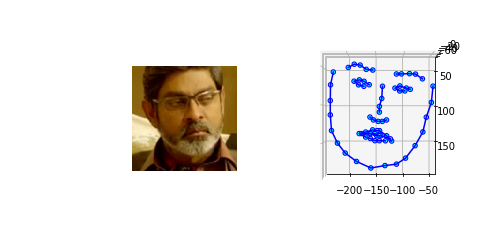

In [27]:
neg_pitch_angle = 0
lm1_proj_yaw_done = lm1_proj_yaw[:, :3]
lm1_proj_yaw_pitch = np.dot(np.array([[ 1, 0, 0, 0], [0, np.cos(neg_pitch_angle), -np.sin(neg_pitch_angle), 0], [0, np.sin(neg_pitch_angle), np.cos(neg_pitch_angle), 0], [0, 0, 0, 1]]), np.hstack((lm1_proj_yaw_done, np.ones(len(lm1_proj_yaw_done)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj_yaw_pitch[:, :3])

# CHECKING FACE POSE VALUES

In [ ]:
face_poses_0 = cv2.imread('/home/voletiv/Downloads/face_poses/face_poses_0.png')

## YAW

In [ ]:
# Yaw
plt.imshow(face_poses_0[:face_poses_0.shape[0]//3, :])

In [ ]:
# Split the image into the respective yaw faces
def get_breaking_points(face_poses_0):
    whites = []
    for i in range(face_poses_0.shape[1]):
        if np.all(face_poses_0[:face_poses_0.shape[0]//3, i] == 255):
                whites.append(i)

    break_points = []
    whites_range = []
    prev_whites_i = whites[0] - 1
    for i in range(len(whites)):
        if whites[i] - prev_whites_i == 1:
            whites_range.append(whites[i])
            prev_whites_i = whites[i]
        else:
            break_points.append(int(np.round(np.mean(whites_range))))
            whites_range = []
            whites_range.append(whites[i])
            prev_whites_i = whites[i]

    break_points.append(int(np.round(np.mean(whites_range))))
    
    return break_points

In [ ]:
# yaw_break_points = get_breaking_points(face_poses_0[:face_poses_0.shape[0]//3, :])
yaw_break_points = [8, 97, 174, 251, 322, 390, 466, 536, 605, 675, 748, 836]

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for b in range(len(yaw_break_points) - 1):
    plt.imshow(face_poses_0[:face_poses_0.shape[0]//3, yaw_break_points[b]:yaw_break_points[b+1]])
    time.sleep(.5)
    fig.canvas.draw()

In [ ]:
yaw_images_list = []
for b in range(len(yaw_break_points) - 1):
    yaw_images_list.append(face_poses_0[:face_poses_0.shape[0]//3, yaw_break_points[b]:yaw_break_points[b+1]])
#     cv2.imwrite(os.path.join('/home/voletiv/Downloads/face_poses/', 'face_poses_0_yaw_%02d.png' % b), face_poses_0[:face_poses_0.shape[0]//3, yaw_break_points[b]:yaw_break_points[b+1]])

## PITCH

In [ ]:
# pitch_break_points = get_breaking_points(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, :])
pitch_break_points = [18, 106, 177, 248, 319, 393, 464, 532, 605, 671, 745, 830]
print(pitch_break_points)

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for b in range(len(pitch_break_points) - 1):
    plt.imshow(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, pitch_break_points[b]:pitch_break_points[b+1]])
    time.sleep(.5)
    fig.canvas.draw()

In [ ]:
pitch_images_list = []
for b in range(len(pitch_break_points) - 1):
    pitch_images_list.append(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, pitch_break_points[b]:pitch_break_points[b+1]])
#     cv2.imwrite(os.path.join('/home/voletiv/Downloads/face_poses/', 'face_poses_0_pitch_%02d.png' % b), face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, pitch_break_points[b]:pitch_break_points[b+1]] )

## ROLL

In [ ]:
# roll_break_points = get_breaking_points(face_poses_0[2*face_poses_0.shape[0]//3:, :])
roll_break_points = [2, 100, 171, 270, 334, 398, 464, 532, 606, 680, 768, 849]
print(roll_break_points)

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for b in range(len(roll_break_points) - 1):
    plt.imshow(face_poses_0[2*face_poses_0.shape[0]//3:, roll_break_points[b]:roll_break_points[b+1]])
    time.sleep(.5)
    fig.canvas.draw()

In [ ]:
roll_images_list = []
for b in range(len(roll_break_points) - 1):
    roll_images_list.append(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, roll_break_points[b]:roll_break_points[b+1]])
#     cv2.imwrite(os.path.join('/home/voletiv/Downloads/face_poses/', 'face_poses_0_roll_%02d.png' % b), face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, roll_break_points[b]:roll_break_points[b+1]] )

## Check yaw

In [ ]:
yaw_ypr0 = []
yaw_ypr1 = []
yaw_lms = []
for y, yaw_image in enumerate(yaw_images_list):
    print(y)
    lm = fa.get_landmarks(yaw_image)[0]
    yaw_lms.append(lm)
    image_points = np.array([lm[38],
                             lm[44],
                             lm[30],
                             lm[48],
                             lm[54],
                             lm[00],
                             lm[16]], dtype='float32')
    image_points = np.array(image_points[:, :2])
    proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points)
    yaw_ypr0.append([y_1, p_1, r_1])
    yaw_ypr1.append([ypr_1])

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for landmarks, image in zip(yaw_lms, yaw_images_list):
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(image)
    ax.plot(landmarks[0:17, 0], landmarks[0:17, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[17:22, 0], landmarks[17:22, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[22:27, 0], landmarks[22:27, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[27:31, 0], landmarks[27:31, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[31:36, 0], landmarks[31:36, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[36:42, 0], landmarks[36:42, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[42:48, 0], landmarks[42:48, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[48:60, 0], landmarks[48:60, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[60:68, 0], landmarks[60:68, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.axis('off')
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(landmarks[:, 0]*1.2, landmarks[:,1], landmarks[:, 2], c="cyan", alpha=1.0, edgecolor='b')
    ax.plot3D(landmarks[:17, 0]*1.2, landmarks[:17,1], landmarks[:17,2], color='blue' )
    ax.plot3D(landmarks[17:22, 0]*1.2, landmarks[17:22, 1], landmarks[17:22, 2], color='blue')
    ax.plot3D(landmarks[22:27, 0]*1.2, landmarks[22:27, 1], landmarks[22:27, 2], color='blue')
    ax.plot3D(landmarks[27:31, 0]*1.2, landmarks[27:31, 1], landmarks[27:31, 2], color='blue')
    ax.plot3D(landmarks[31:36, 0]*1.2, landmarks[31:36, 1], landmarks[31:36, 2], color='blue')
    ax.plot3D(landmarks[36:42, 0]*1.2, landmarks[36:42, 1], landmarks[36:42, 2], color='blue')
    ax.plot3D(landmarks[42:48, 0]*1.2, landmarks[42:48, 1], landmarks[42:48, 2], color='blue')
    ax.plot3D(landmarks[48:60, 0]*1.2, landmarks[48:60, 1], landmarks[48:60, 2], color='blue' )
    ax.plot3D(landmarks[60:, 0]*1.2, landmarks[60:, 1], landmarks[60:, 2], color='blue' )
    ax.view_init(elev=90., azim=90.)
    ax.set_xlim(ax.get_xlim()[::-1])
    fig.canvas.draw()
    time.sleep(.5)

In [ ]:
yaw_ypr0 = np.array(yaw_ypr0).reshape(-1, 3)
print(yaw_ypr0)

In [ ]:
yaw_ypr1 = np.array(yaw_ypr1).reshape(-1, 3)
print(yaw_ypr1)

## Check Pitch

In [ ]:
pitch_ypr0 = []
pitch_ypr1 = []
pitch_lms = []
for p, pitch_image in enumerate(pitch_images_list):
    print(p)
    lm = fa.get_landmarks(pitch_image)
    if lm is not None:
        lm = lm[0]
        pitch_lms.append(lm)
        image_points = np.array([lm[38],
                                 lm[44],
                                 lm[30],
                                 lm[48],
                                 lm[54],
                                 lm[00],
                                 lm[16]], dtype='float32')
        image_points = np.array(image_points[:, :2])
        proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points)
        pitch_ypr0.append([y_1, p_1, r_1])
        pitch_ypr1.append([ypr_1])

In [ ]:
pitch_ypr0 = np.array(pitch_ypr0).reshape(-1, 3)
print(pitch_ypr0)

In [ ]:
pitch_ypr1 = np.array(pitch_ypr1).reshape(-1, 3)
print(pitch_ypr1)

## Check Roll

In [ ]:
roll_ypr0 = []
roll_ypr1 = []
roll_lms = []
for p, roll_image in enumerate(roll_images_list):
    print(p)
    lm = fa.get_landmarks(roll_image)
    if lm is not None:
        lm = lm[0]
        roll_lms.append(lm)
        image_points = np.array([lm[38],
                                 lm[44],
                                 lm[30],
                                 lm[48],
                                 lm[54],
                                 lm[00],
                                 lm[16]], dtype='float32')
        image_points = np.array(image_points[:, :2])
        proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points)
        roll_ypr0.append([y_1, p_1, r_1])
        roll_ypr1.append([ypr_1])

In [ ]:
roll_ypr0 = np.array(roll_ypr0).reshape(-1, 3)
print(roll_ypr0)

In [ ]:
roll_ypr1 = np.array(roll_ypr1).reshape(-1, 3)
print(roll_ypr1)

In [ ]:
np.round(roll_ypr0[:, 2])

In [ ]:
exp_proj_1 = np.vstack((proj_1, np.array([0, 0, 0, 1]).reshape(1, -1)))
rev_proj_1 = np.vstack((np.hstack((proj_1[:, :3].T, -proj_1[:, 3].reshape(-1, 1))), np.array([0, 0, 0, 1]).reshape(1, -1)))
print(rev_proj_1.shape)

In [ ]:
lm1_proj = np.dot(exp_proj_1, np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj[:, :3])

In [ ]:
lm1_proj.shape

In [ ]:
lm1_rev_proj = np.dot(rev_proj_1, np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_rev_proj)

In [ ]:
# Camera marix
camera_matrix = np.array([[20, 0, 160], [0, 20, 120], [0, 0, 1]], dtype='float64')
print(camera_matrix, camera_matrix.shape, type(camera_matrix[0][0]))

In [ ]:
# Distortion coefficients
distortion_coeffs = np.array([0, 0, 0, 0, 0]).astype('float32').reshape(-1, 1)
print(distortion_coeffs.shape, type(distortion_coeffs[0][0]))

In [ ]:
# Rotation vector
d = np.array([[1, 0, 0], [0, -1, 0,], [0, 0, -1]], dtype=('float32'))
rvec = cv2.Rodrigues(d)[0]
print(rvec, rvec.shape, type(rvec[0][0]))

In [ ]:
# Translation vector
tvec = np.array([0, 0, 1]).astype('float32').reshape(3, 1)
print(tvec, tvec.shape, type(tvec[0][0]))

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(object_points, image_points_0_flip, camera_matrix, distortion_coeffs, rvec, tvec, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
# obj_pts = np.array([[10,60,0],
#                     [10,60,12.6],
#                     [24,60,0],
#                     [24,60,12.6],
#                     [24,74,0],
#                     [24,74,12.6],
#                     [47.7,70,8.8]
#                    ], dtype=np.float32)

obj_pts = np.array([[-36.9522, 39.3518, 47.1217],
                    [35.446, 38.4345, 47.6468],
                    [-0.0697709, 18.6015, 87.9695],
                    [-27.6439, -29.6388, 73.8551],
                    [28.7793, -29.2935, 72.7329],
                    [-87.2155, 15.5829, -45.1352],
                    [85.8383, 14.9023, -46.3169]
                   ], dtype=np.float32)/35.

# img_pts = np.array([[96.,  72.],
#                     [160.,  64.],
#                     [133., 112.],
#                     [109., 148.],
#                     [159., 141.],
#                     [ 38.,  76.],
#                     [186.,  55.]
#                    ], dtype=np.float32)

# img_pts = np.array([[800,970],
#                     [689,329],
#                     [1380,1175],
#                     [1363,458],
#                     [1842,881],
#                     [1875,256],
#                     [3052,852]
#                    ], dtype=np.float32)

w = 224
h = 224
ppa     = (w/2., h/2.)
fm      = 7.5/1e3
sensor  = (7.14e-3, 5.36e-3)
focal   = w*(fm / sensor[0])

cam_mat = np.array( [[focal, 0, ppa[0]],
                     [0, focal, ppa[1]],
                     [0, 0, 1]], dtype = np.float64
                  )

# cam_mat = np.array( [[20, 0, 160],
#                      [0, 20, 120],
#                      [0, 0, 1]], dtype = np.float64
#                   )
  
dist_coeffs = np.zeros((5,1))

rvecc = np.zeros((3,1))
# d = np.array([[1, 0, 0], [0, -1, 0,], [0, 0, -1]], dtype=('float32'))
# rvecc = cv2.Rodrigues(d)[0]

tvecc = np.zeros((3,1)) 
# tvecc = np.array([0., 0., 1.])

flag = cv2.SOLVEPNP_ITERATIVE # tried with SOLVEPNP_EPNP, same error.

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_0, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_1, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
# Image points of im0
lm2 = np.array(telugu_Mahesh_Babu_landmarks[25][1:])
image_points_3D_2 = np.array([lm2[38],
                              lm2[44],
                              lm2[30],
                              lm2[48],
                              lm2[54],
                              lm2[00],
                              lm2[16]], dtype='float32')
image_points_2 = np.array(image_points_3D_2[:, :2])
print(image_points_3D_2.shape, image_points_2.shape)

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_2, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
proj_matrix_2 = proj_matrix

### Projecting one landmark into another

In [ ]:
print(np.hstack((image_points_3D_1, np.ones(len(image_points_3D_1)).reshape(-1, 1))).shape, proj_matrix_2.T.shape)

In [ ]:
image_points_3D_1_straight = np.dot(np.hstack((image_points_3D_1, np.ones(len(image_points_3D_1)).reshape(-1, 1))), proj_matrix_2.T)

In [ ]:
image_points_3D_1_straight.shape

In [ ]:
image_points_3D_1_straight = np.array(image_points_3D_1_straight[:, :2])

In [ ]:
image_points_3D_1_straight.shape

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_3D_1_straight, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)